Yue wirte the code in 2023/08/09

The aim is to derive the kinematic formula between motor angles and end position and to test it on our leg

In the test, I use position control to make the leg move as a desired trajectory.

# mathmatic rule

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import odrive

## geometry1


In [11]:
x=179.99
y=0.001
#
L5=65
L4=60
L3=120
L2=130
L1=70
# theta1_ori=194/360
# theta2_ori=244/360

bd=np.sqrt((x-L5)**2+y**2)
beta1=math.atan(y/(L5-x))%math.pi
beta2=math.atan(y/x)%math.pi
ad=np.sqrt(x**2+y**2)
alpha1=math.acos((L1**2+bd**2-L2**2)/(2*L1*bd))%math.pi
alpha2=math.acos((L4**2+ad**2-L3**2)/(2*L4*ad))%math.pi
theta1=math.pi-alpha1-beta1
theta2=alpha2+beta2

print('alpha1:{}  alpha2:{}'.format(alpha1/math.pi*180,alpha2/math.pi*180))
print('beta1:{}  beta2:{}'.format(beta1/math.pi*180,beta2/math.pi*180))
print('theta1:{}  theta2:{}'.format(theta1/math.pi*180,theta2/math.pi*180))
# theta_input1=theta1_ori-theta1/2/math.pi
# theta_input2=theta2_ori-theta2/2/math.pi




alpha1:85.64415020354627  alpha2:0.8541287739592214
beta1:179.99950173250272  beta2:0.0003183275710455736
theta1:-85.643651936049  theta2:0.854447101530267


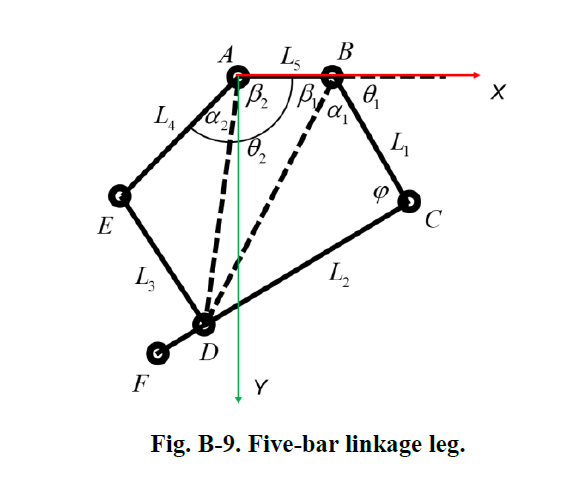


## geometry2


In [ ]:
leg=80
x=50.1
y=0


if x==0:
    alpha=math.pi/2
else:
    alpha=math.atan(y/x)

ad=np.sqrt(x**2+y**2)
if ad>=2*leg or ad<=0 or y>0:
    print('Error:position out of reach')
else:
    beta=math.acos(ad/(2*leg))%math.pi

theta1=alpha-beta
theta2=alpha+beta

print(theta1/math.pi*180,theta2/math.pi*180)

<img src="leg_geometry.jpg" alt="drawing" width="500"/>

# position control to verify

In [ ]:
import odrive
from odrive.enums import *
import time
import math
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from IPython.display import clear_output
import numpy as np
import serial
import pickle
ORIGIN_POS=[0.177-0.25,0.041+0.25]
LEG=80

def check(my_drive):
    if my_drive.axis1.error == 0:
        print('Everything is fine')
    else:
        print('Error!')


def lowpass_filter(data,cutoff,fs,order):
    b,a=butter(order,2*cutoff/fs,btype='low',analog=False)
    y=filtfilt(b,a,data)
    return y 


def motor_pos_at(x,y):
    ad=np.sqrt(x**2+y**2)

    if ad>=2*LEG or ad<=0 or y<0:
        raise ValueError('position out of motion range')
    else:
        beta=math.acos(ad/(2*LEG))%math.pi
        
        if x==0:
            alpha=math.pi/2
        else:
            alpha=math.atan(y/x)%math.pi

        theta0=alpha-beta
        theta1=alpha+beta

        pos_0=ORIGIN_POS[0]+theta0/(2*math.pi)
        pos_1=ORIGIN_POS[1]-theta1/(2*math.pi)

        return pos_0,pos_1

def letsgo(end_pos,load_time,show_position=1):
    t0=time.monotonic()
    delta=time.monotonic()-t0
    sample_num=0
    start_pos=[my_drive.axis0.controller.pos_setpoint,my_drive.axis1.controller.pos_setpoint]
    load_speed_0=(end_pos[0]-start_pos[0])/load_time
    load_speed_1=(end_pos[1]-start_pos[1])/load_time

    while delta<load_time:
        delta=time.monotonic()-t0
        sample_num+=1

        pos_input_0=start_pos[0]+load_speed_0*delta
        pos_input_1=start_pos[1]+load_speed_1*delta

        my_drive.axis0.controller.input_pos = pos_input_0
        my_drive.axis1.controller.input_pos = pos_input_1

        if sample_num%20==0 and show_position==1:
            pos_mea_0=my_drive.axis0.encoder.pos_circular
            pos_mea_1=my_drive.axis1.encoder.pos_circular
            clear_output()

            print('POSITION INPUT \nAXIS0:{:.2f} degree \nAXIS1:{:.2f} degree'.format(pos_input_0*360,pos_input_1*360))
            print('*'*20)
            print('POSITION MEASURED \nAXIS0:{:.2f} degree \n AXIS1:{:.2f} degree'.format(pos_mea_0*360,pos_mea_1*360))

    print('control frequecy=',sample_num/load_time)



## test1: go to a specific point

In [95]:
# Find a connected ODrive (this will block until you connect one)
print("finding an odrive...")
my_drive = odrive.find_any()
print("Found! and the bus voltage is " + str(my_drive.vbus_voltage) + "V")
print(my_drive.axis0.motor.current_control.i_gain,my_drive.axis1.motor.current_control.i_gain)
my_drive.axis1.motor.current_control.i_gain = 4
my_drive.axis0.motor.current_control.i_gain = 4
print(my_drive.axis0.motor.current_control.i_gain,my_drive.axis1.motor.current_control.i_gain)


my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
my_drive.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL


check(my_drive)
print('*'*50)


finding an odrive...
Found! and the bus voltage is 25.961719512939453V
80.16718292236328 82.6633529663086
4.0 4.0
Everything is fine
**************************************************


In [97]:
# my_drive.axis1.motor.config.torque_constant = 1
print(my_drive.axis0.motor.config.torque_constant,my_drive.axis1.motor.config.torque_constant)
POS_GAIN=200
my_drive.axis0.controller.config.pos_gain = POS_GAIN
my_drive.axis1.controller.config.pos_gain = POS_GAIN
print('vel_gain and pos_gain of AXIS0 is',my_drive.axis0.controller.config.vel_gain,my_drive.axis0.controller.config.pos_gain)
print('vel_gain and pos_gain of AXIS1 is',my_drive.axis1.controller.config.vel_gain,my_drive.axis1.controller.config.pos_gain)
# my_drive.save_configuration()

1.0 1.0
vel_gain and pos_gain of AXIS0 is 8.0 200.0
vel_gain and pos_gain of AXIS1 is 8.0 200.0


In [ ]:
print('AXIS0: control_mode={}; pos_setpoint={:.4f} turns; pos_measured={:.4f} turns'.format(my_drive.axis0.controller.config.control_mode,my_drive.axis0.controller.pos_setpoint,my_drive.axis0.encoder.pos_circular))
print('AXIS1: control_mode={}; pos_setpoint={:.4f} turns; pos_measured={:.4f} turns'.format(my_drive.axis1.controller.config.control_mode,my_drive.axis1.controller.pos_setpoint,my_drive.axis1.encoder.pos_circular))

In [ ]:
letsgo(motor_pos_at(100,100),1)
letsgo(motor_pos_at(0,50),1)
letsgo(motor_pos_at(-100,120),1)
letsgo(motor_pos_at(0,50),1)


## test2: follow a trajetory

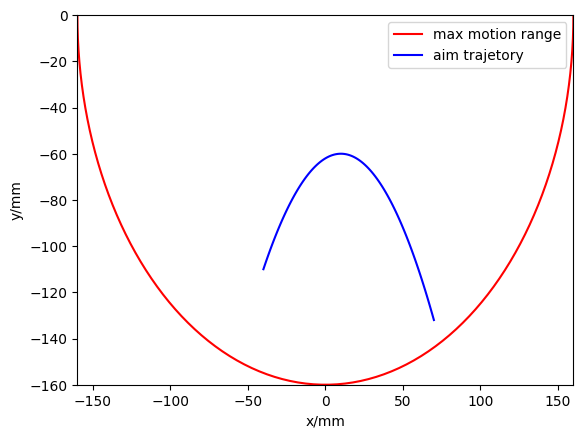

In [98]:
def traje_function(x):
    return (x-10)**2/50+60
x1=-40
x2=70


x_seq=np.linspace(x1,x2,100)
y_seq=traje_function(x_seq)
theta=np.linspace(-math.pi,0,100)
plt.plot(160*np.cos(theta),160*np.sin(theta),'r',label='max motion range')
plt.plot(x_seq,-y_seq,'b',label='aim trajetory')
plt.xlim(-160,160)
plt.ylim(-160,0)
plt.xlabel('x/mm')
plt.ylabel('y/mm')
plt.legend()
plt.show()

In [103]:
pos_input_seq=[]
pos_measured_seq=[]
delta_seq=[]

finish_time=2

print('going to the begin point')
letsgo(motor_pos_at(x_seq[0],y_seq[0]),2,0)
clear_output()
print('ready to go')
time.sleep(1)
print('following the given trajectory')
t0=time.monotonic()
delta=time.monotonic()-t0
sample_num=0

while delta<finish_time:
    # time.sleep(0.005)
    delta=time.monotonic()-t0
    sample_num+=1
    x_now=delta/finish_time*(x2-x1)+x1
    y_now=traje_function(x_now)
    pos=motor_pos_at(x_now,y_now)
    pos_mea=[my_drive.axis0.encoder.pos_circular,my_drive.axis1.encoder.pos_circular]

    my_drive.axis0.controller.input_pos = pos[0]
    my_drive.axis1.controller.input_pos = pos[1]

    delta_seq.append(delta)
    pos_input_seq.append(pos[0]*360)
    pos_measured_seq.append(pos_mea[0]*360)

    if sample_num%20==0:
        
        clear_output()
        print('POSITION INPUT \nAXIS0:{:.2f} degree \nAXIS1:{:.2f} degree'.format(pos[0]*360,pos[1]*360))
        print('*'*20)
        print('POSITION MEASURED \nAXIS0:{:.2f} degree \n AXIS1:{:.2f} degree'.format(pos_mea[0]*360,pos_mea[1]*360))

control_fre=sample_num/finish_time
print('control frequecy=',sample_num/finish_time)


POSITION INPUT 
AXIS0:8.78 degree 
AXIS1:16.14 degree
********************
POSITION MEASURED 
AXIS0:8.47 degree 
 AXIS1:14.80 degree
control frequecy= 305.5


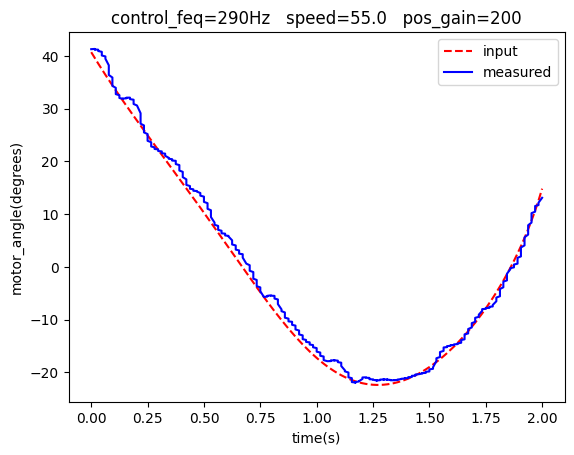

In [102]:
for i in range(len(pos_measured_seq)):
    if pos_measured_seq[i]>300:
        pos_measured_seq[i]=pos_measured_seq[i]-360
plt.plot(delta_seq,pos_input_seq,'r',linestyle='dashed',label='input')
plt.plot(delta_seq,pos_measured_seq,'b',label='measured')

plt.title('control_feq={}Hz   speed={:.1f}   pos_gain={}'.format(int(control_fre),(x2-x1)/finish_time,POS_GAIN))
plt.xlabel('time(s)')
plt.ylabel('motor_angle(degrees)')
plt.legend()
plt.show()


In [ ]:
a=np.array([1,2,3,4])
b=a.reshape(2,-1)
print(b)

In [ ]:
pos_measured_array=np.array(pos_measured_seq).reshape(2,-1)
print(pos_measured_array.shape)
plt.plot(delta_seq,pos_measured_array[0,:])
plt.show()
print(delta_seq,pos_measured_array[0,:])

In [ ]:
print(len(pos_input_seq),len(pos_measured_seq),len(delta_seq))
pos_input_array=np.array(pos_input_seq).reshape(2,-1)
print(pos_input_array.shape)
plt.plot(delta_seq,pos_input_array[0,:])
plt.show()
print(pos_input_array[0,:])